# Purpose
This notebook serves as an exploratory analysis of new metrics created in this project. The primary metrics used are differentials, which measure the difference in the rate of techniques used between a fighter and his opponent. For instance, if fighter A lands 50 strikes-per-minute, and fighter B lands 30 strikes-per-minute, fighter A has a strikes-per-minute-differential (S/PM-Di) of 20, and fighter B would be rated at -20.
#### Limitations
This metric rates low accuracy strikers with great defense as being equal to high accuracy fighters with poor defense, beacuse the rate gets lower with every punch the fighter recieves.

As a case study for these metrics we are going to compare Khabib Nurmagomedov with Conor McGregor. Khabib is considered one of the best wrestlers of all time, while Conor is considered to be one of the best strikers of all time. In their matchup, Conor was unable to effectively use his striking against Khabib, and Khabib took him down repeatedly before submitting him. We want to see if our new metrics capture the nature of this performance better than the metrics commonly used in Mixed Martial Arts today.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from sqlalchemy import create_engine
from src import local
from src import functions
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

### Grappling Stats import
Here we import our grappling stats data, this has advanced statistics on reversals, submission attempts, and guard passes for every round in the UFC. We also import our ground strikes and takedown stats, which measure how many strikes are landed on the ground and how many takedowns an opponent lands. Each row in this data set is a single round in the UFC.

In [5]:
grappling = pd.read_csv('../../data/ufcstats_data/advanced_stats/grappling_stats.csv')
ground_strikes = pd.read_csv('../../data/ufcstats_data/advanced_stats/ground_ss_stats.csv')
takedowns = pd.read_csv('../../data/ufcstats_data/advanced_stats/takedown_stats.csv')
grappling.head()

,round,bout_link,fighter_link,rev_p1m,rev_p15m,pass_p1m,pass_p15m,sub_att_p1m,sub_att_p15m,rev_pr_di,rev_p1m_di,rev_p15m_di,pass_pr_di,pass_p1m_di,pass_p15m_di,sub_att_pr_di,sub_att_p1m_di,sub_att_p15m_di
0,1,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,2,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.2,3.0,0.0,0.0,0,0.0,0.0,1,0.2,3.0,0,0.0,0.0
2,3,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
3,4,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
4,5,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0


#### In order to get name and date information, we need to merge these dataframes with our bouts and fighters tables. For this, we'll use sql as it will allow us to specify the exact rows we want.

In [7]:
# Credentials
USER = local.user 
PASS = local.password
HOST = local.host
PORT = local.port
#create engine
engine = create_engine(f'postgresql://{USER}:{PASS}@{HOST}:{PORT}/match_finder')

query = """
SELECT name, link
FROM fighters
"""

fighters = pd.read_sql(query, engine)

fighters.head()

,name,link
0,Fabiano Scherner,http://www.ufcstats.com/fighter-details/0bc7e6...
1,Alexandre Dantas,http://www.ufcstats.com/fighter-details/8dc46e...
2,Kevin Burns,http://www.ufcstats.com/fighter-details/a6d8bf...
3,Joseph Sandoval,http://www.ufcstats.com/fighter-details/696002...
4,Jose Aldo,http://www.ufcstats.com/fighter-details/d0f395...


In [8]:
query = """
SELECT "Date" as date, bouts.link
FROM bouts
JOIN events on events.link = bouts.event_link
"""
bouts = pd.read_sql(query, engine)

bouts.head()

,date,link
0,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...
1,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...
2,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...
3,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...
4,"July 25, 2020",http://www.ufcstats.com/fight-details/11f715fa...


Each fighter name can be linked to the stat tables using the unique fighter_link identifier. Then all dates will be connected via the bout_link identifier

In [9]:
grappling = grappling.join(fighters.set_index('link'), on='fighter_link')
ground_strikes = ground_strikes.join(fighters.set_index('link'), on='fighter_link')
takedowns = takedowns.join(fighters.set_index('link'), on='fighter_link')

In [10]:
grappling = grappling.join(bouts.set_index('link'), on='bout_link')
ground_strikes = ground_strikes.join(bouts.set_index('link'), on='bout_link')
takedowns = takedowns.join(bouts.set_index('link'), on='bout_link')

#### We have some rows with missing names, we remove them here

In [40]:
grappling.dropna(subset=['name'], inplace=True, axis=0)
ground_strikes.dropna(subset=['name'], inplace=True, axis=0)
takedowns.dropna(subset=['name'], inplace=True, axis=0)

#### Removing fighters with less than 3 fights

In [212]:
# calculate number of bouts for each fighter
bouts_by_name = pd.DataFrame(takedowns.groupby(['bout_link', 'fighter_link']).name.max())
number_of_bouts = bouts_by_name.groupby('name').name.count()

# subset only the fighters who have had at least 3 bouts
experienced_fighters = list(number_of_bouts[number_of_bouts>=3].index)

# Remove inexperienced fighters
mask = takedowns['name'].isin(experienced_fighters)
takedowns = takedowns[mask]

mask = ground_strikes['name'].isin(experienced_fighters)
ground_strikes = ground_strikes[mask]

mask = grappling['name'].isin(experienced_fighters)
grappling = grappling[mask]

### Measuring Takedown performance
we can easily get the career averages by grouping a column by the fighters name and getting the average for whatever stat we want. First we'll look at the the Takedown Successes Differential per 15 Minutes, which is denoted as td_s_p15m_di in our table. This is a measure of how many more takedowns a fighter landed than their opponent for each 15 minutes they've fought in the UFC.

In [283]:
def compare_stat(stat_df, stat, fighter_1='Conor McGregor', fighter_2='Khabib Nurmagomedov', graphic_des=False, fighter_1_offset=.1, fighter_2_offset=.1):
    min_stat_rating = (stat_df.groupby('name')[stat].mean()).describe()['min']
    max_stat_rating = (stat_df.groupby('name')[stat].mean()).describe()['max']
    median_stat_rating = (stat_df.groupby('name')[stat].mean()).describe()['50%']

    #### Calculate stats for each fighter

    fighter_2_stat = stat_df[stat_df['name']==fighter_2][stat].mean()
    fighter_1_stat = stat_df[stat_df['name']==fighter_1][stat].mean()

    if fighter_1_stat>median_stat_rating:
        fighter_1_pos = 'bottom'
        fighter_1_col = 'tab:blue'
    else:
        fighter_1_pos = 'top'
        fighter_1_col = 'tab:red'
    if fighter_2_stat>median_stat_rating:
        fighter_2_pos = 'bottom'
        fighter_2_col = 'tab:blue'
    else:
        fighter_2_pos = 'top'
        fighter_2_col = 'tab:red'
        
        
        
    plt.style.use('ggplot')
    
    if graphic_des:
        #### Here's one for graphic design use
        fig, ax = plt.subplots(1,1, figsize=(5, 10))

        ax.set_ylim(min_stat_rating, max_stat_rating)
        ax.text(x=-0.125, y=fighter_1_stat-fighter_1_offset, 
                s=str(round(fighter_1_stat, 2)), 
                ha='center', 
                va=fighter_1_pos, 
                fontsize=35)
        ax.text(x=0.125, y=fighter_2_stat-fighter_2_offset, 
                s=str(round(fighter_2_stat, 2)), 
                ha='center', 
                va=fighter_2_pos, 
                fontsize=35)
        ax.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            labelbottom=False)

        ax.bar(x=[-0.125], height=[fighter_1_stat], bottom=median_stat_rating, color=fighter_1_col, width=.2)
        ax.bar(x=[.125], height=[fighter_2_stat], bottom=median_stat_rating, color=fighter_2_col, width=.2)
        plt.xticks([-.125,.125], labels=[fighter_1, fighter_2], fontsize=25)
        plt.yticks([median_stat_rating, max_stat_rating, min_stat_rating], labels=['Average\nRating', 'Best\nRating', 'Worst\nRating'], fontsize=25)
        plt.tight_layout()
        plt.savefig('../../report/figures/con_kha_'+stat+'.png', transparent=True)

    else:
        fig, ax = plt.subplots(1,1, figsize=(5, 10))

        ax.set_ylim(min_stat_rating, max_stat_rating)
        ax.text(x=-0.125, y=fighter_1_stat-fighter_1_offset, 
                s=str(round(fighter_1_stat, 2)), 
                ha='center', 
                va=fighter_1_pos, 
                fontsize=35)
        ax.text(x=0.125, y=fighter_2_stat-fighter_2_offset, 
                s=str(round(fighter_2_stat, 2)), 
                ha='center', 
                va=fighter_2_pos, 
                fontsize=35)
        ax.set_ylabel(stat)
        plt.xticks([-.125,.125], labels=[fighter_1, fighter_2], fontsize=25)
        plt.yticks([median_stat_rating, max_stat_rating, min_stat_rating], labels=['Average\nRating', 'Best\nRating', 'Worst\nRating'], fontsize=25)
        ax.bar(x=[-0.125], height=[fighter_1_stat], bottom=median_stat_rating, color=fighter_1_col, width=.2)
        ax.bar(x=[.125], height=[fighter_2_stat], bottom=median_stat_rating, color=fighter_2_col, width=.2);

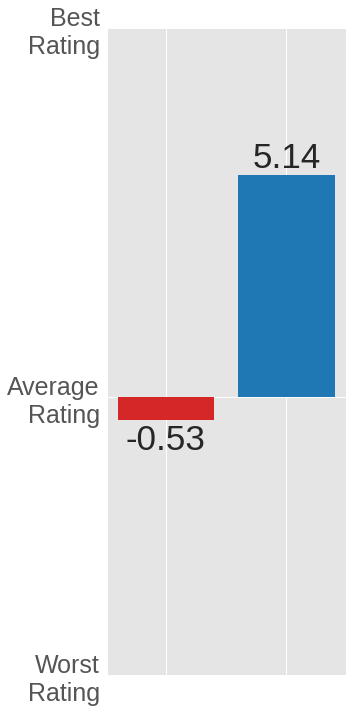

In [291]:
compare_stat(takedowns, 'td_s_p15m_di', graphic_des=True, fighter_1_offset=.3, fighter_2_offset=.2)

### Ground Strike performance

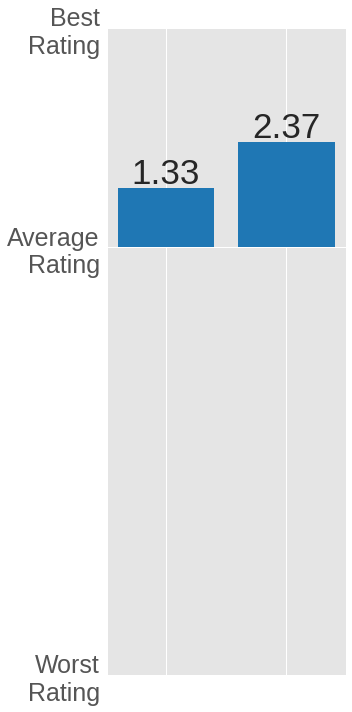

In [294]:
compare_stat(ground_strikes, 'ground_s_p1m_di', graphic_des=True, fighter_1_offset=.1, fighter_2_offset=.1)

### Submission performance

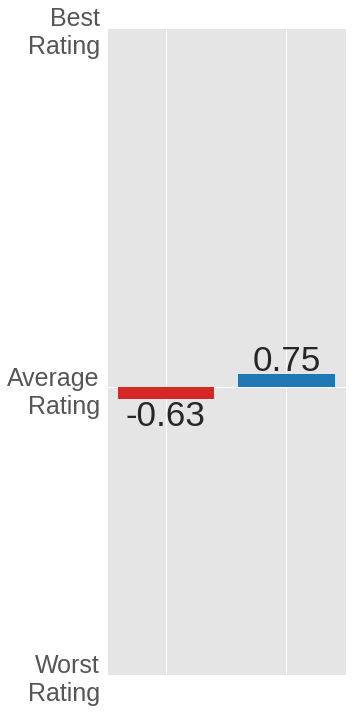

In [299]:
compare_stat(grappling, 'sub_att_p15m_di', graphic_des=True, fighter_1_offset=0, fighter_2_offset=.2)

## Striking Stats

In [300]:
distance_ss_stats = pd.read_csv('../../data/ufcstats_data/advanced_stats/distance_ss_stats.csv')
knockdown_stats = pd.read_csv('../../data/ufcstats_data/advanced_stats/knockdown_stats.csv')

Each fighter name can be linked to the stat tables using the unique fighter_link identifier. Then all dates will be connected via the bout_link identifier

In [301]:
distance_ss_stats

,round,bout_link,fighter_link,distance_a_p1m,distance_s_p1m,distance_a_p15m,distance_s_p15m,distance_ac,distance_de,distance_s_pr_di,distance_a_pr_di,distance_s_p1m_di,distance_a_p1m_di,distance_s_p15m_di,distance_a_p15m_di
0,1,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,5.800000,2.000000,87.000000,30.000000,0.344828,0.666667,4,11,0.800000,2.200000,12.000000,33.000000
1,2,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,4.600000,2.000000,69.000000,30.000000,0.434783,0.750000,7,11,1.400000,2.200000,21.000000,33.000000
2,3,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,6.000000,2.200000,90.000000,33.000000,0.366667,0.750000,6,10,1.200000,2.000000,18.000000,30.000000
3,4,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,6.200000,2.400000,93.000000,36.000000,0.387097,0.625000,6,15,1.200000,3.000000,18.000000,45.000000
4,5,http://www.ufcstats.com/fight-details/11f715fa...,http://www.ufcstats.com/fighter-details/e1147d...,5.200000,2.800000,78.000000,42.000000,0.538462,0.476190,3,5,0.600000,1.000000,9.000000,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25767,1,http://www.ufcstats.com/fight-details/693e4a0b...,http://www.ufcstats.com/fighter-details/669a3c...,0.600000,0.000000,9.000000,0.000000,0.000000,0.782609,-5,-20,-1.000000,-4.000000,-15.000000,-60.000000
25768,2,http://www.ufcstats.com/fight-details/693e4a0b...,http://www.ufcstats.com/fighter-details/669a3c...,3.037975,0.000000,45.569620,0.000000,0.000000,0.454545,-6,-7,-4.556962,-5.316456,-68.354430,-79.746835
25769,1,http://www.ufcstats.com/fight-details/c6f85419...,http://www.ufcstats.com/fighter-details/a54a35...,3.157895,1.403509,47.368421,21.052632,0.444444,0.466667,-4,-6,-1.403509,-2.105263,-21.052632,-31.578947
25770,1,http://www.ufcstats.com/fight-details/1db8bed8...,http://www.ufcstats.com/fighter-details/911fb2...,0.400000,0.000000,6.000000,0.000000,0.000000,NaN,0,2,0.000000,0.400000,0.000000,6.000000


In [302]:
distance_ss_stats = distance_ss_stats.join(fighters.set_index('link'), on='fighter_link')
knockdown_stats = knockdown_stats.join(fighters.set_index('link'), on='fighter_link')

distance_ss_stats = distance_ss_stats.join(bouts.set_index('link'), on='bout_link')
knockdown_stats = knockdown_stats.join(bouts.set_index('link'), on='bout_link')

#### We have some rows with missing names, we remove them here
distance_ss_stats.dropna(subset=['name'], inplace=True, axis=0)
knockdown_stats.dropna(subset=['name'], inplace=True, axis=0)

#### Removing fighters with less than 3 fights

In [303]:
# calculate number of bouts for each fighter
bouts_by_name = pd.DataFrame(takedowns.groupby(['bout_link', 'fighter_link']).name.max())
number_of_bouts = bouts_by_name.groupby('name').name.count()

# subset only the fighters who have had at least 3 bouts
experienced_fighters = list(number_of_bouts[number_of_bouts>=3].index)

# Remove inexperienced fighters
mask = distance_ss_stats['name'].isin(experienced_fighters)
distance_ss_stats = distance_ss_stats[mask]
mask = knockdown_stats['name'].isin(experienced_fighters)
knockdown_stats = knockdown_stats[mask]

#### Average Knockdowns

In [304]:
knockdown_stats.groupby('name').kd_p15m_di.mean().sort_values(ascending=False)[:20]

name
Mark Weir                23.275862
Todd Duffee              18.583838
James Irvin              15.893056
David Terrell            12.500000
Johnny Walker            12.229385
Jairzinho Rozenstruik    10.574169
Ryan Jimmo                9.196148
Duane Ludwig              8.942909
Michal Oleksiejczuk       8.867263
Drew McFedries            8.780509
Anthony Johnson           8.697515
Chan Sung Jung            7.982335
Damir Hadzovic            7.972098
Abdul Razak Alhassan      7.928666
Justin Lawrence           7.375706
Benji Radach              7.266667
Kenan Song                6.958647
Sergei Pavlovich          6.835531
Devonte Smith             6.632822
Che Mills                 6.428571
Name: kd_p15m_di, dtype: float64

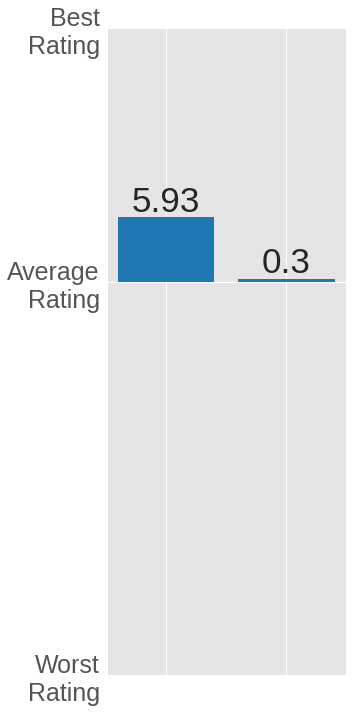

In [306]:
compare_stat(knockdown_stats, 'kd_p15m_di', graphic_des=True)

In [307]:
distance_ss_stats.groupby('name').distance_s_p1m_di.mean().sort_values(ascending=False)[:15]

name
Todd Duffee           3.715165
Sean O'Malley         3.516286
Sergei Pavlovich      3.260773
Devonte Smith         3.140336
Ruslan Magomedov      2.688889
Xiaonan Yan           2.653333
Alexander Volkov      2.618961
Ryan Janes            2.615172
Joanna Jedrzejczyk    2.579341
Chris Gutierrez       2.550958
Cristiane Justino     2.549651
Johnny Walker         2.308788
Amanda Nunes          2.222690
Anthony Johnson       2.107243
Ciryl Gane            2.097284
Name: distance_s_p1m_di, dtype: float64

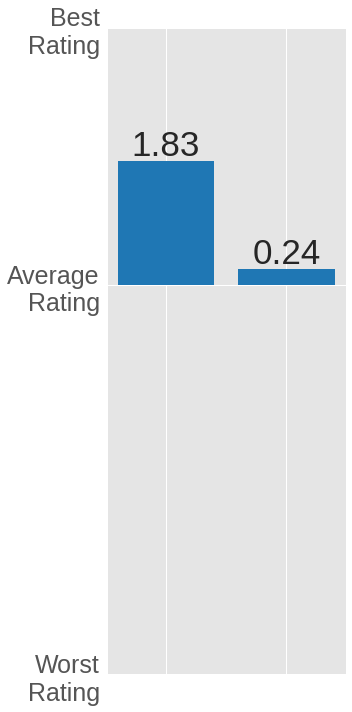

In [308]:
compare_stat(distance_ss_stats, 'distance_s_p1m_di', graphic_des=True)

In [309]:
takedowns.groupby('name').dif_minus_av.mean().sort_values()[:15]

AttributeError: 'DataFrameGroupBy' object has no attribute 'dif_minus_av'

This list doesn't have any familiar names, which is unsuprising, but if we look at the #2 spot, Jason Gonzalez, we'll notice that he fought Gregor Gilespie, our #7 ranked in takedown differential. 

This metric measures the number of takedowns that a fighter has given up and could be a good measurement of takedown defense.

### Submission attempts

In [75]:
mask = grappling.name.map(lambda x: functions.black_list_entry(x, inexperienced_fighters))
grappling = grappling[mask]

grappling.groupby('name').sub_att_p15m_di.mean().sort_values(ascending=False)[:15]

name
Ian Entwistle        19.497616
Ronda Rousey          7.800269
Sean McCorkle         7.407751
Paul Sass             7.218045
Rob Broughton         6.825243
Teemu Packalen        6.750000
Rousimar Palhares     6.291708
Genki Sudo            5.374214
TJ Waldburger         5.315116
Renato Sobral         4.920935
Patrick Williams      4.891304
Manny Bermudez        4.841381
Matt Arroyo           4.659574
Fabiano Iha           4.604762
Marcus Aurelio        4.446429
Name: sub_att_p15m_di, dtype: float64

In [78]:
grappling.groupby('name').pass_p15m_di.mean().sort_values(ascending=False)[:15]

name
Gregor Gillespie       13.220946
Tatiana Suarez         10.066494
Teemu Packalen          9.250000
Grant Dawson            8.779592
Murilo Bustamante       8.506452
Gillian Robertson       8.092862
Denis Kang              7.751553
Jake Rosholt            7.506276
Ronda Rousey            6.498034
Aspen Ladd              6.140637
Edmen Shahbazyan        5.666667
Claudio Silva           5.578009
Khabib Nurmagomedov     5.429699
Jimy Hettes             5.357632
Misha Cirkunov          5.107617
Name: pass_p15m_di, dtype: float64

In [80]:
grappling['combined_grappling_p15m_di'] = grappling['pass_p15m_di'] + grappling['sub_att_p15m_di'] + grappling['rev_p15m_di']
grappling.groupby('name').combined_grappling_p15m_di.mean().sort_values(ascending=False)[:20]

name
Ronda Rousey         19.869731
Ian Entwistle        18.268107
Teemu Packalen       15.000000
Gregor Gillespie     14.348343
Murilo Bustamante    11.777419
Genki Sudo           10.224538
Manny Bermudez       10.101642
Grant Dawson         10.010204
Gillian Robertson     9.435001
Tatiana Suarez        9.286136
Rousimar Palhares     8.947319
Misha Cirkunov        8.585120
TJ Waldburger         7.997151
Edmen Shahbazyan      7.750000
Diego Ferreira        7.694718
Joe Duffy             7.310531
Denis Kang            7.285714
Joe Lauzon            7.177872
Livinha Souza         6.904762
Claudio Silva         6.904596
Name: combined_grappling_p15m_di, dtype: float64

In [84]:
av_sub_att = grappling.groupby('name').sub_att_p15m_di.mean()

av_sub_att[av_sub_att.index == 'Demian Maia']

name
Demian Maia    1.045441
Name: sub_att_p15m_di, dtype: float64

In [86]:
av_rev = grappling.groupby('name').rev_p15m_di.mean()

av_rev[av_rev.index == 'Demian Maia']

name
Demian Maia   -0.023621
Name: rev_p15m_di, dtype: float64

In [87]:
av_pass = grappling.groupby('name').pass_p15m_di.mean()

av_pass[av_pass.index == 'Demian Maia']

name
Demian Maia    3.722007
Name: pass_p15m_di, dtype: float64

In [22]:
av_rev = takedowns.groupby('name').td_s_p15m_di.mean()

av_rev[av_rev.index == 'Conor McGregor']

name
Conor McGregor   -0.530995
Name: td_s_p15m_di, dtype: float64